# Transfer learning for CNN

* [source site](https://www.tensorflow.org/beta/tutorials/images/transfer_learning)

### codes

1. Examine and understand the data
1. Build an input pipeline with keras.ImageDataGenerator
1. Compose model
  * Load pretrained model
  * Stack classification layer on top
1. Train & Evaluate model

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
# note that don't need to use sklearn library
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


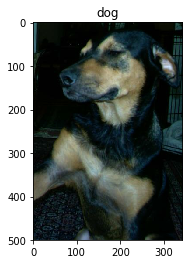

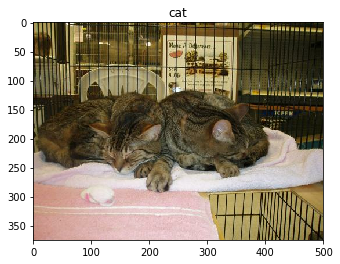

In [4]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [5]:
for image, label in raw_train.take(1):
    print(tf.cast(image, tf.float32)/127.5-1)

tf.Tensor(
[[[-0.00392157  0.2313726   0.2941177 ]
  [-0.23137254  0.02745104  0.082353  ]
  [-0.24705881  0.05882359  0.11372554]
  ...
  [-0.64705884 -0.5764706  -0.6156863 ]
  [-0.6313726  -0.56078434 -0.6       ]
  [-0.60784316 -0.5529412  -0.60784316]]

 [[-0.23137254  0.00392163  0.06666672]
  [-0.46666664 -0.20784312 -0.15294117]
  [-0.47450978 -0.16862744 -0.11372548]
  ...
  [-1.         -0.92941177 -0.96862745]
  [-1.         -0.92941177 -0.96862745]
  [-0.9843137  -0.92941177 -0.9843137 ]]

 [[-0.21568626  0.0196079   0.082353  ]
  [-0.45098037 -0.19215685 -0.1372549 ]
  [-0.46666664 -0.1607843  -0.10588235]
  ...
  [-0.9843137  -0.90588236 -0.96862745]
  [-0.96862745 -0.8901961  -0.9529412 ]
  [-0.94509804 -0.8901961  -0.94509804]]

 ...

 [[-0.5529412  -0.35686272 -0.30196077]
  [-0.88235295 -0.7019608  -0.654902  ]
  [-0.9372549  -0.7882353  -0.75686276]
  ...
  [-0.78039217 -0.78039217 -0.7176471 ]
  [-0.827451   -0.827451   -0.7647059 ]
  [-0.90588236 -0.92156863 -0.819

In [6]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32) # original data are tensor int8 type. 
    image = (image/127.5) - 1 # -1 to 1 scale. why not use 0-1?
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [7]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

W0628 14:02:58.394218 139915804030784 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


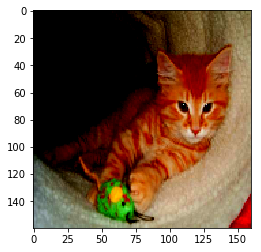

In [10]:
plt.imshow(image_batch[0,:])

In [11]:
label_batch[:3]

<tf.Tensor: id=616, shape=(3,), dtype=int64, numpy=array([0, 1, 0])>

### load pretrained model and build model

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # pretrained with imagenet

In [13]:
feature_batch = base_model(image_batch)
print(feature_batch.shape) # extracted as conv net feature.

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False # freeze pretrained model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch) # test for batch feature extracted
print(feature_batch_average.shape) # why not use just flatten? 

(32, 1280)


In [16]:
prediction_layer = keras.layers.Dense(1) # don't need softmax, because just binary classification.
prediction_batch = prediction_layer(feature_batch_average)# test for batch extracted above feature
print(prediction_batch.shape) 

(32, 1)


In [17]:
# confirmed the unit test, build whole model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model with cat vs dog data

In [19]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10 # total number of samples is 23262
  for weight in SPLIT_WEIGHTS # (8, 1, 1)
) # count the number of samples in each data set.

In [20]:
initial_epochs = 10
steps_per_epoch = np.ceil(num_train/BATCH_SIZE)
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps) #initial loss and accurary wo training

20/20 [==============================] - 2s 95ms/step - loss: 6.8957 - accuracy: 0.4422


In [21]:
class CollectBatchStats(tf.keras.callbacks.Callback): # to viualize training progress.
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
      #  self.model.reset_metrics() # not epoch average, but each batch average
batch_stats_callback = CollectBatchStats()

In [22]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    #steps_per_epoch=steps_per_epoch, # this code line make interrupt the model when they begin 2nd epoch. 
                    # it said that the training data was ran out.
                    validation_data=validation_batches,
                   callbacks = [batch_stats_callback]) # I don't why, if this code added, the result differ from original code.
                    # I assume it conflicting with the batch normalization layer.
                    # model.reset_metrics may be the conflicting part with the batch norm.

Epoch 1/10


W0628 14:03:05.589577 139915804030784 deprecation.py:323] From /home/hyunsu/anaconda3/envs/tf20_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 39s 67ms/step - loss: 3.3150 - accuracy: 0.6482 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 39s 68ms/step - loss: 1.2321 - accuracy: 0.8344 - val_loss: 0.7575 - val_accuracy: 0.8909
Epoch 3/10
582/582 [==============================] - 41s 70ms/step - loss: 0.8685 - accuracy: 0.8864 - val_loss: 0.4848 - val_accuracy: 0.9289
Epoch 4/10
582/582 [==============================] - 42s 72ms/step - loss: 0.7305 - accuracy: 0.9040 - val_loss: 0.4176 - val_accuracy: 0.9435
Epoch 5/10
582/582 [==============================] - 41s 70ms/step - loss: 0.6492 - accuracy: 0.9153 - val_loss: 0.3820 - val_accuracy: 0.9478
Epoch 6/10
582/582 [==============================] - 41s 71ms/step - loss: 0.5941 - accuracy: 0.9233 - val_loss: 0.3641 - val_accuracy: 0.9487
Epoch 7/10
582/582 [==============================] - 40s 69ms/step - loss: 0.5539 - accuracy: 0.9295 - val_loss: 0.3354 - val_accuracy: 0.

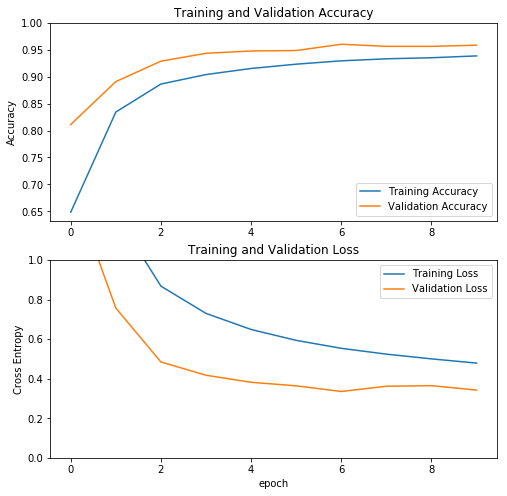

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [24]:
base_model.trainable = True # unfreeze the base model

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [27]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [29]:
len(model.trainable_variables)

58

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
582/582 [==============================] - 52s 89ms/step - loss: 0.4300 - accuracy: 0.9461 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/20
582/582 [==============================] - 37s 63ms/step - loss: 0.3339 - accuracy: 0.9714 - val_loss: 0.2168 - val_accuracy: 0.9703
Epoch 13/20
582/582 [==============================] - 38s 65ms/step - loss: 0.2840 - accuracy: 0.9789 - val_loss: 0.1942 - val_accuracy: 0.9728
Epoch 14/20
582/582 [==============================] - 38s 65ms/step - loss: 0.2557 - accuracy: 0.9817 - val_loss: 0.2152 - val_accuracy: 0.9720
Epoch 15/20
582/582 [==============================] - 38s 65ms/step - loss: 0.2449 - accuracy: 0.9837 - val_loss: 0.2203 - val_accuracy: 0.9737
Epoch 16/20
582/582 [==============================] - 38s 65ms/step - loss: 0.2338 - accuracy: 0.9842 - val_loss: 0.2249 - val_accuracy: 0.9741
Epoch 17/20
582/582 [==============================] - 38s 66ms/step - loss: 0.2282 - accuracy: 0.9850 - val_loss: 0.2182 

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss'] # add history end of the initial epoch traning

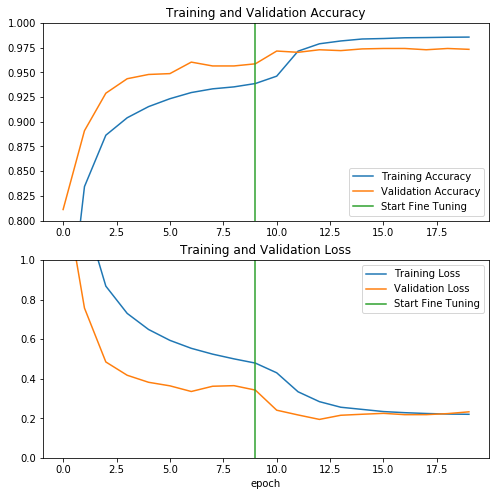

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()